**Project Topic**

I am an avid Fantasy Football player.  While Fantasy Football is largely a game of luck, I am constantly looking for ways to improve my discussion making process. 

In most of my fantasy football leagues, there are 12 teams that compete against each other every week during the NFL season by seeing whose selected NFL players scored the most fantasy points that week.  The players are selected via a draft.  The draft is basically a queue of NFL players.  The fantasy teams take turns selecting NFL players for their fantasy teams.  Once a player is selected, that player cannot be select one of the other 11 fantasy teams.

Each year, around August, professional Fantasy Football analysts give their tiers of players.  These are generally groups of players that are ranked near each other in that analyst’s rankings and there is a perceived gap in between the tiers.  These tiers are useful when deciding between NFL players to select.  For example, say you are in the process of selecting a player and your next pick is in 6 sections.  You have one RB left in a tier and 10 WRs.  In this scenario, it probably makes sense to select the RB because that RB will not likely last to your selection, but you know one of the WRs in the tier will. While the analysts typically provide their reasoning behind their tiers, I have long felt that clustering algorithms might be a useful tool for tiering NFL players for Fantasy Football. So, for this project, I will use a couple of clustering algorithms to tier players based on their previous year's basic statistics.

For this project to be successful, there is really two criteria that need to be met.  There needs to be a reasonable number of clusters, and they need to be somewhat predictive of future PPG.  Too few or too many clusters are not useful.  Starting this project, I really know how many clusters is optimal. I do however feel that there should be at least 4 clusters.

Generally, I prefer leagues that use full PPR and can have up to 4 WRs in thier starting lineup each week.  In a full PPR league, fantasy players receive a full point every time an NFL player in the lineup catches a pass. In this type of league WRs are very valuable.  So, this project will focus on WRs only.

**Data and Data Cleaning**

This project will mostly rely on basic WR stats from the Fantasy Pros Website: https://www.fantasypros.com/nfl/stats/qb.php?scoring=PPR

The final output will include the recent 'Consensus Ranking' from Fantasy Pros, which I downloaded prior to my draft.  The 'Consensus Ranking' includes 'TIERS' from thier human experts and can be use for comparison to our clustering algorithm results.  The 'Consensus Ranking' is not used in the clustering algorithm.  It is merely for comparison.

FantasyPros allows for the download of tabular csv files, after signing up for a free subscription.

Import potentially needed libraries

In [746]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import MeanShift,AgglomerativeClustering, KMeans, AffinityPropagation
from scipy.cluster.hierarchy import dendrogram
from sklearn.metrics import mean_squared_error, silhouette_score
pd.options.mode.chained_assignment = None  # default='warn'

In [747]:
fldr = r"/Users/dennisyoung/Documents/FantasyFootballClustering"

In [748]:
outfile = fldr + "/" + "cluster.csv"

Loading the "Consensus Ranking" from Fantasy Pros.  This file is only used for comparing to our final models.  During the data exploration phase, I realized that "Marquise Brown" is listed as "Hollywood Brown" in the "Consensus Ranking" and "Marquise Brown" in the players stats data.  So, changed the name below for merging.

This data was pulled before my draft.  Here is the most recent file: https://www.fantasypros.com/nfl/rankings/ppr-wr-cheatsheets.php.  It may be slightly different that the one used for this project.

In [749]:
## Read in the file
file = fldr + "/" + "2024" + "/" + "FantasyPros_2024_Draft_ALL_Rankings.csv"
consensus = pd.read_csv(file)

## Filtering to only include WRs
consensus = consensus[(consensus['PLAYER NAME'].notna()) & (consensus['POS'].str.contains("WR"))]
consensus = consensus.rename(columns={'PLAYER NAME':'Player'})                                          

## Change 'Hollywood Brown' to 'Marquise Brown' to be consistent with the player stats
consensus = consensus.replace({'Player': {'Hollywood Brown':'Marquise Brown'}})

## Display the first five records in the file
consensus.head()

,RK,TIERS,Player,TEAM,POS,BYE WEEK,SOS SEASON,ECR VS. ADP
1,2,1,CeeDee Lamb,DAL,WR1,7,3 out of 5 stars,+1
2,3,1,Tyreek Hill,MIA,WR2,6,2 out of 5 stars,-1
3,4,1,Ja'Marr Chase,CIN,WR3,12,2 out of 5 stars,+2
4,5,1,Amon-Ra St. Brown,DET,WR4,5,4 out of 5 stars,+3
6,7,2,Justin Jefferson,MIN,WR5,6,3 out of 5 stars,0


Load the WR statistic that was downloaded as csv files from Fantasy Pros.

Note the years are the year the season started.  So, stat for the current season are 2024 and the prior full year is 2023.

In [750]:
WR_yr_list = ["2017","2018","2019","2020","2021","2022","2023","2024"]

WR = pd.DataFrame()

for yr in WR_yr_list:
    file = fldr + "/" + yr + "/" + "FantasyPros_Fantasy_Football_Statistics_WR.csv"
    WR_yr = pd.read_csv(file) 
    WR_yr['year'] = pd.to_numeric(yr)
    WR_yr = WR_yr[WR_yr['Player'].notna()]
    WR = pd.concat([WR,WR_yr])

The potential features are receptions ('REC'), targets ('TGT'), recieving yard ('YDS'), yars per reception ('Y/R'), longest reception ('LG'), number of receptions of 20 yards or more (20+), receiving TDs (TD), rushing attempts ('ATT'), rushing yards ('YTDS.1'), rushing TDS ('TD.1'), fumbles for loss ('FL'), and games played ('G').  We can also use fantasy points per game ('FPTS/G'), but I prefer to use the components for the clustering algorithm.

In [751]:
WR.head()

,Rank,Player,REC,TGT,YDS,Y/R,LG,20+,TD,ATT,YDS.1,TD.1,FL,G,FPTS,FPTS/G,ROST,year
0,1.0,Antonio Brown (FA),101.0,163.0,"1,533",15.2,57.0,14.0,9.0,0.0,0.0,0.0,0.0,14.0,310.3,22.2,0.8%,2017
1,2.0,DeAndre Hopkins (TEN),96.0,174.0,"1,378",14.4,72.0,13.0,13.0,0.0,0.0,0.0,1.0,15.0,309.8,20.7,55.7%,2017
2,3.0,Keenan Allen (CHI),102.0,159.0,"1,393",13.7,51.0,13.0,6.0,2.0,9.0,0.0,0.0,16.0,278.2,17.4,72.2%,2017
3,4.0,Larry Fitzgerald (FA),109.0,161.0,"1,156",10.6,37.0,14.0,6.0,0.0,0.0,0.0,1.0,16.0,261.4,16.3,0.2%,2017
4,5.0,Jarvis Landry (FA),112.0,161.0,987,8.8,49.0,5.0,9.0,1.0,-7.0,0.0,2.0,16.0,260.0,16.3,14.0%,2017


The 'Player' column in the file contains the current NFL team of the player.  We are going to strip that out for merging in the next step.  Also, "Deebo Samuel" is listed as "Deebo Samuel Sr." in certain years.  We are going to make it so he is listed as "Deebo Samuel Sr." in all years to be consistent with the "Consensus Ranking".

In [752]:
WR['Player'] = WR['Player'].str.split("(").str[0].str.strip()
WR['Player'] = WR['Player'].str.replace("Deebo Samuel","Deebo Samuel Sr.")

**Exploritory Data Analysis (EDA)**

Our primary comparison is going to be next year's PPG (points per game).  I prefer PPG to total points because injuries are highly unpredicatable.  The statistic file includes PPG, listed as 'FPTS/G'.  We will merge the stats file back to itself using a different year and will the next year's PPG as 'PPG'.

In [753]:
## Create a smaller version of the WR statistics file with a new year to add 'PPG' as the response variable
## Used for model evaluation, not for training the model.
WR_next = WR[['Player','FPTS/G','year']]
WR_next['nxt_yr'] = WR_next['year'] - 1
WR_next = WR_next[['Player','FPTS/G','nxt_yr']].rename(columns = {'nxt_yr':'year',
                                                                 'FPTS/G':'PPG'})
##  Merge the next file onto original WR statisics file.
WR = WR.merge(WR_next,how = "left", on =['Player','year'])

## Basic information on the data.
WR.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2202 entries, 0 to 2201
Data columns (total 19 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Rank    2202 non-null   float64
 1   Player  2202 non-null   object 
 2   REC     2202 non-null   float64
 3   TGT     2202 non-null   float64
 4   YDS     2202 non-null   object 
 5   Y/R     2202 non-null   float64
 6   LG      2202 non-null   float64
 7   20+     2202 non-null   float64
 8   TD      2202 non-null   float64
 9   ATT     2202 non-null   float64
 10  YDS.1   2202 non-null   float64
 11  TD.1    2202 non-null   float64
 12  FL      2202 non-null   float64
 13  G       2202 non-null   float64
 14  FPTS    2202 non-null   float64
 15  FPTS/G  2202 non-null   float64
 16  ROST    2202 non-null   object 
 17  year    2202 non-null   int64  
 18  PPG     1416 non-null   float64
dtypes: float64(15), int64(1), object(3)
memory usage: 344.1+ KB


The info method shows that there are missing values for 'PPG'.  This is expected since the first year 2017 will be missing for all records and first year players will also have missing values.

Recieving years, 'YDS', is an 'object' Dtype.  This is unexpected and will need to be changed to a numeric data type for this project.

The histagram below for 'FPTS/G', the PPG that corresponds to the player statistics shows that the majority of NFL players have a PPG of zero.  I am only really interested in drafting NFL players that had at least 5 PPG in the previous year, or did not play in the previous year.

<AxesSubplot:xlabel='FPTS/G', ylabel='Count'>

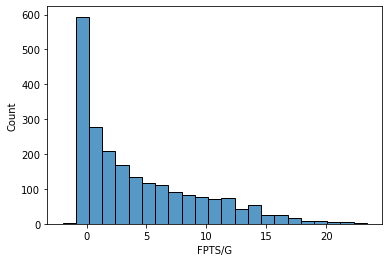

In [754]:
sns.histplot(WR['FPTS/G'])

In the step below, we records were the player had less than 5 PPG in the previous year and covert recieving yards to a numeric feature.

In [755]:
WR = WR[WR['FPTS/G'] >= 7]
WR = WR[WR['YDS'].notna()]
WR['YDS'] = WR['YDS'].str.replace(",","")
WR['YDS'] = pd.to_numeric(WR['YDS'])
WR.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 585 entries, 0 to 1956
Data columns (total 19 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Rank    585 non-null    float64
 1   Player  585 non-null    object 
 2   REC     585 non-null    float64
 3   TGT     585 non-null    float64
 4   YDS     504 non-null    float64
 5   Y/R     585 non-null    float64
 6   LG      585 non-null    float64
 7   20+     585 non-null    float64
 8   TD      585 non-null    float64
 9   ATT     585 non-null    float64
 10  YDS.1   585 non-null    float64
 11  TD.1    585 non-null    float64
 12  FL      585 non-null    float64
 13  G       585 non-null    float64
 14  FPTS    585 non-null    float64
 15  FPTS/G  585 non-null    float64
 16  ROST    585 non-null    object 
 17  year    585 non-null    int64  
 18  PPG     475 non-null    float64
dtypes: float64(16), int64(1), object(2)
memory usage: 91.4+ KB


The receiving yards feature is now a numeric data type.

Now, that we have cleaned the data a little, let's look at some histograms of the key components that go into PPG: recieving yards ('YDS), receptions ('REC'),  and recieving touchdowns ('TD')

I prefer to look at most these statistic an a per game basis.  So, we will devide several features by game played 'G'

In [756]:
lst = ['REC','TGT','YDS','TD','ATT','YDS.1','TD.1','FL','20+']

for item in lst:
    WR[item] = WR[item] /WR['G'] 

Receiving yards appear to be somewhat evenly distributed and centered around 40 yds game.

In [800]:
WR.head()

,Rank,Player,REC,TGT,YDS,Y/R,LG,20+,TD,ATT,YDS.1,TD.1,FL,G,FPTS,FPTS/G,ROST,year,PPG
0,1.0,Antonio Brown,7.214286,11.642857,109.500000,15.2,57.0,1.000000,0.642857,0.0000,0.0000,0.0,0.000000,14.0,310.3,22.2,0.8%,2017,21.6
1,2.0,DeAndre Hopkins,6.400000,11.600000,91.866667,14.4,72.0,0.866667,0.866667,0.0000,0.0000,0.0,0.066667,15.0,309.8,20.7,55.7%,2017,20.8
2,3.0,Keenan Allen,6.375000,9.937500,87.062500,13.7,51.0,0.812500,0.375000,0.1250,0.5625,0.0,0.000000,16.0,278.2,17.4,72.2%,2017,16.3
3,4.0,Larry Fitzgerald,6.812500,10.062500,72.250000,10.6,37.0,0.875000,0.375000,0.0000,0.0000,0.0,0.062500,16.0,261.4,16.3,0.2%,2017,11.6
4,5.0,Jarvis Landry,7.000000,10.062500,61.687500,8.8,49.0,0.312500,0.562500,0.0625,-0.4375,0.0,0.125000,16.0,260.0,16.3,14.0%,2017,13.6


<AxesSubplot:xlabel='YDS', ylabel='Count'>

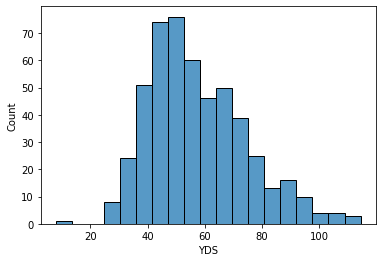

In [757]:
sns.histplot(WR['YDS'])

Receptions per game appear to be somewhat normally distributed as well.

<AxesSubplot:xlabel='REC', ylabel='Count'>

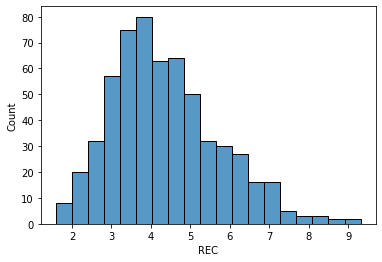

In [758]:
sns.histplot(WR['REC'])

Receiving TDs tend to be centered around one every four games, with some players scoring more than 1 per game.

<AxesSubplot:xlabel='TD', ylabel='Count'>

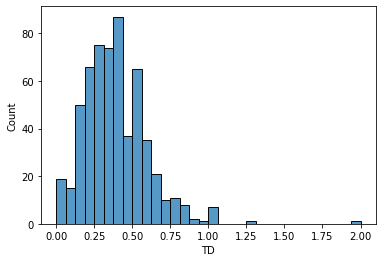

In [759]:
sns.histplot(WR['TD'])

The number of players per year seems to be fairly evenly distributed with a little bit of a dip in 2023.

<AxesSubplot:xlabel='year', ylabel='Count'>

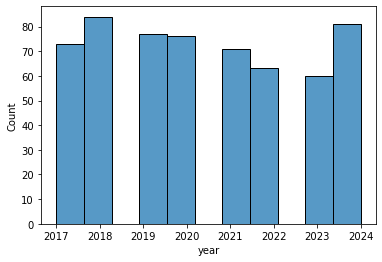

In [760]:
sns.histplot(WR['year'])

For clustering, it is not always necessary to split into testing and training data.  However, we will look split by year to see if the model still did a good job of stratifying the PPG in the clusters in the most current full year ('test') and so far this season ('output')

Note, I tried scaling the features in an early iteration, but it seemed to descrease the performance of the models.

In [761]:
df = WR[['Player','year','REC','TGT','Y/R','YDS','LG','TD','YDS.1','TD.1','FL','FPTS/G','G','PPG','20+']]

## Split the data by year
train = df[df['year'].isin([2018,2019,2021,2022])]
test = df[df['year'].isin([2022])]
output = df[df['year'].isin([2023])]

We are going to use the next year's PPG ('PPG') to evaluate our model.  Because of this, we will filter out records where the NFL player did not score any fantasy points the next year from our training.

In [762]:
train = train[(train['PPG'] > 0) & (train['PPG'].notna())]

Now, that we have are data let's look at how the various features are correlated.  Unsurprisingly, targets ('TGT') and receptions ('REC') are highly correlated.  I expect those features to be correlated with receiving yards ('YDS'), but the correlation is higher than I expected.

<AxesSubplot:>

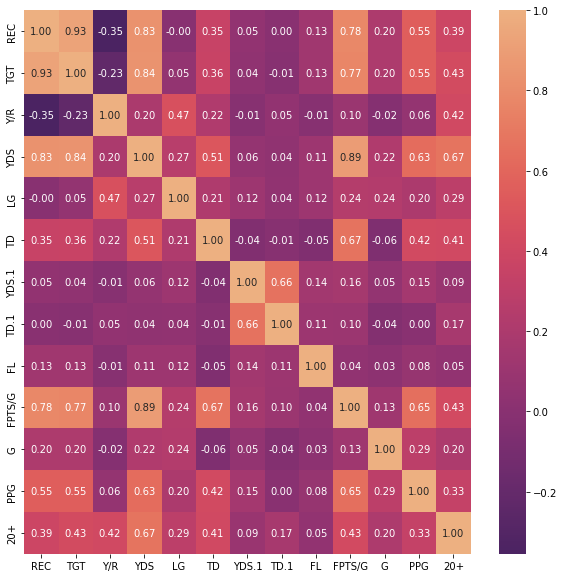

In [763]:
train_features = train[['REC','TGT','Y/R','YDS','LG','TD','YDS.1','TD.1','FL','FPTS/G','G','PPG','20+']]

fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(train_features.corr(), annot = True , fmt=".2f", cmap = "flare_r", ax=ax)

Below is the pair plot for our potential features.

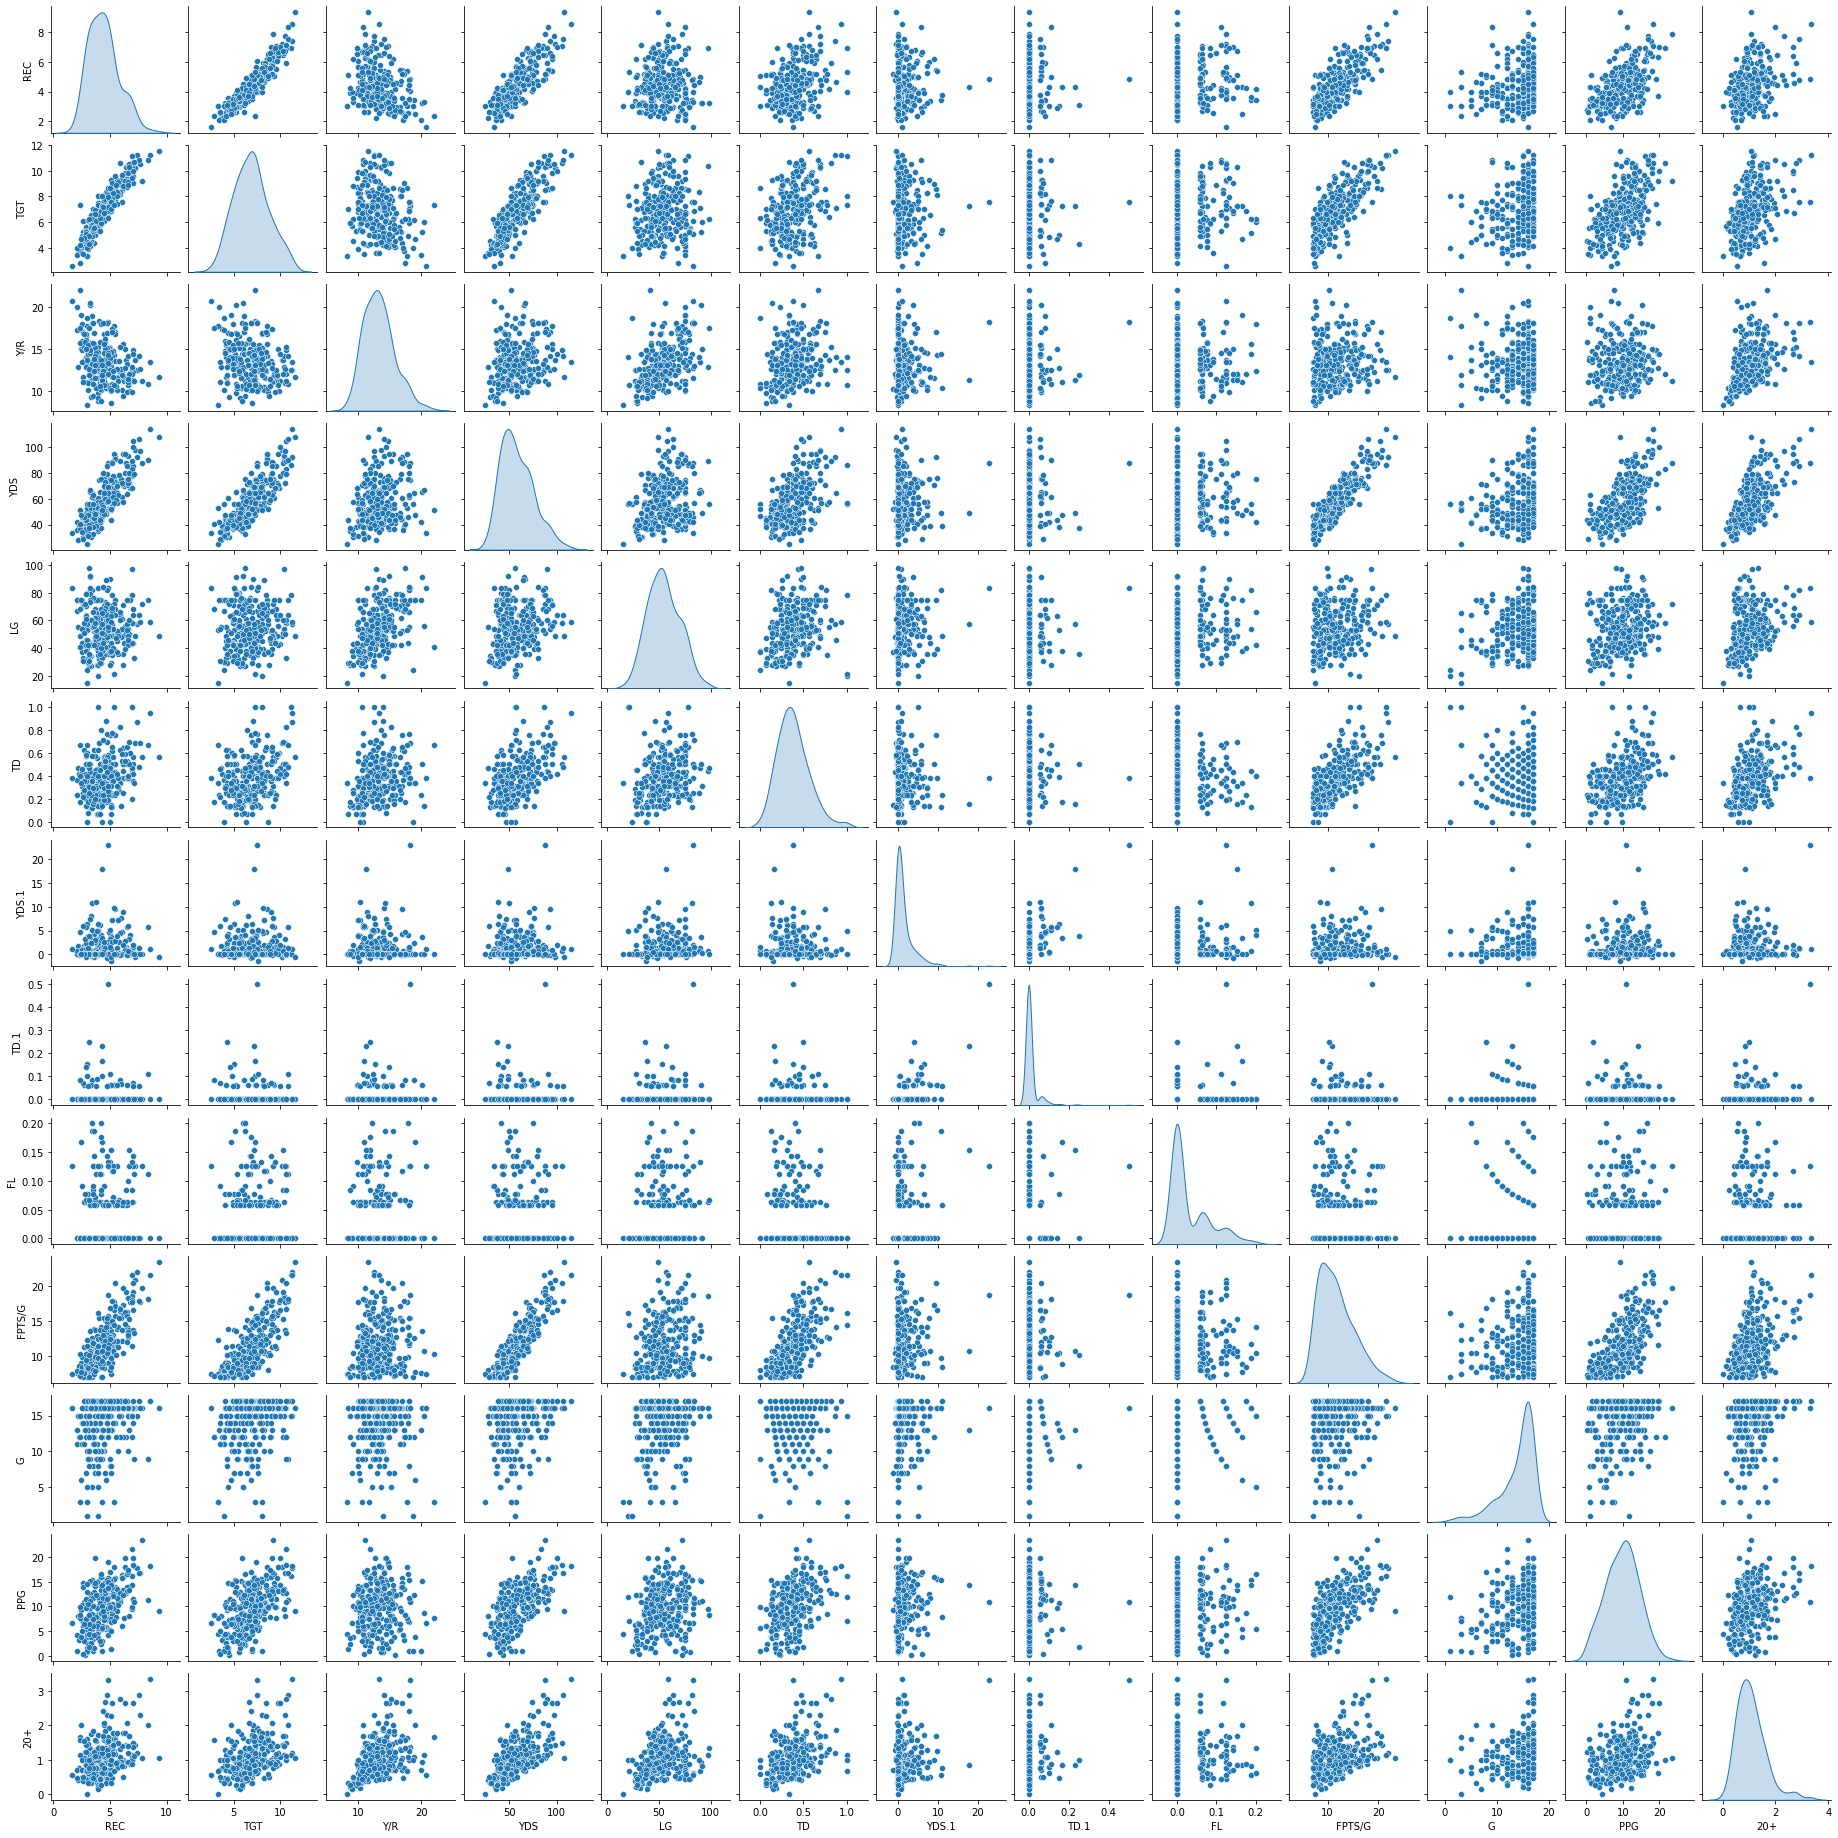

In [764]:
sns.pairplot(train_features, palette="Set1", diag_kind="kde", height=2)

In [765]:
train.head()

,Player,year,REC,TGT,Y/R,YDS,LG,TD,YDS.1,TD.1,FL,FPTS/G,G,PPG,20+
229,DeAndre Hopkins,2018,7.187500,10.187500,13.7,98.250000,49.0,0.687500,-0.4375,0.0000,0.125,20.8,16.0,18.0,1.437500
230,Davante Adams,2018,7.400000,11.266667,12.5,92.400000,57.0,0.866667,0.0000,0.0000,0.000,22.0,15.0,17.7,1.200000
231,Tyreek Hill,2018,5.437500,8.562500,17.0,92.437500,75.0,0.750000,9.4375,0.0625,0.000,20.5,16.0,15.7,1.687500
232,Julio Jones,2018,7.062500,10.625000,14.8,104.812500,58.0,0.500000,0.7500,0.0000,0.125,20.4,16.0,18.3,1.500000
233,Antonio Brown,2018,6.933333,11.200000,12.5,86.466667,78.0,1.000000,0.0000,0.0000,0.000,21.6,15.0,16.1,1.133333


**Build the models**

We will start with hierachical clustering algorthim using the AgglomerativeClustering method from sklearn.  The function below will plot our dendrogram. 

In [766]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)


After playing around with the features, it appears that the combination of yards per game ('YDS'), receiving touchdowns per game ('TD'), rushing yards per game ('YDS.1') and rushing TDs per game ('TD.1') gives the best clusters.  I would like to work on automated feature selection in furture, but at this time, I stuck will manual changes to evaluate how 'PPG' stratified accross the different clusters.

Below is the dendrogram, it look like a distance somewhere between 25 and 40 gives a reasonable number of clusters, not too few or too many.

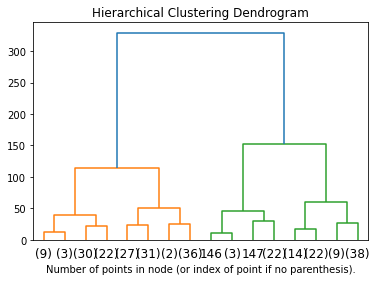

In [767]:
# Select Features that seem to work best
training = train[['YDS','TD','YDS.1','TD.1']]

# distance theshold set to zero to produce full tree if needed.
model_agglo = AgglomerativeClustering(distance_threshold=0, n_clusters=None)

# Plots the dendogram.  The parameter 'p' lets us see how many splits in the dendrogram to plot.
model_agglo = model_agglo.fit(training)
plt.title("Hierarchical Clustering Dendrogram")
# plot the top three levels of the dendrogram
plot_dendrogram(model_agglo, truncate_mode="level", p=3)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

It looks like a distance of 35 gives 8 clusters, which is reasonable.  It also seems to have decent stratifciation for PPG. So, it is predictive.  It also has good stratification accross current PPG ('FPTS/G'). If it did not have good stratification accross 'FPTS/G', then I would need to choose a different value. 

In [768]:
model_agglo_out = AgglomerativeClustering(distance_threshold=35, n_clusters=None)
hier = model_agglo_out.fit(training)
train['hier_clust'] = model_agglo_out.fit_predict(training)

In [769]:
model_agglo_out.n_clusters_

8

<AxesSubplot:xlabel='hier_clust', ylabel='PPG'>

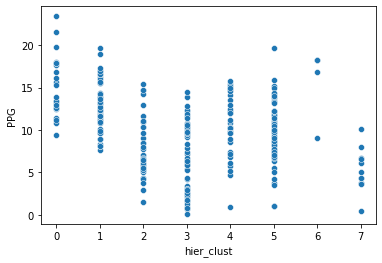

In [770]:
sns.scatterplot(x=train['hier_clust'],y=train['PPG'])

<AxesSubplot:xlabel='hier_clust', ylabel='FPTS/G'>

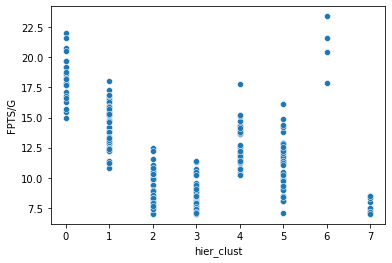

In [771]:
sns.scatterplot(x=train['hier_clust'],y=train['FPTS/G'])

##### The silhouette score can be used to evaluate the speration between clusters.  The score ranges from -1 to 1.  A score close to one implies good clustering.  The score for our model is about 0.423.  It is not very high, but it is above 0, which indicate good clustering.

In [772]:
round(silhouette_score(training, hier.labels_ ),3)

0.423

Let's see how the silouette score changes as the number of clusters increases.  As the number of clusters increases, the silhouette score decreases.  It looks like a silouette score of around 0.42 is a good score for a model using these features.

<AxesSubplot:xlabel='n_cluster', ylabel='score'>

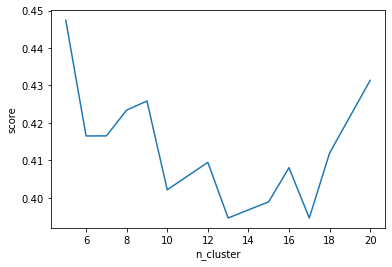

In [792]:
lst = []

for i in range(15, 60, 1):
    model_agglo_tst = AgglomerativeClustering(distance_threshold=i,n_clusters=None)
    sim_test = model_agglo_tst.fit(training)
    score = silhouette_score(training, sim_test.labels_ )
    lst.append((i,model_agglo_tst.n_clusters_,score))

results = pd.DataFrame(lst, columns=['dist','n_cluster','score'])

unique_res = results[['n_cluster','score']].drop_duplicates()
sns.lineplot(data = unique_res, x = 'n_cluster', y = 'score')

Now, lets create a predictive model using the median value in each cluster and calculate the Mean Square Error.
It looks like the MSE goes down as the number clusters increases.  However, it is pretty flat at around a values of 17.

<AxesSubplot:xlabel='n_cluster', ylabel='mse'>

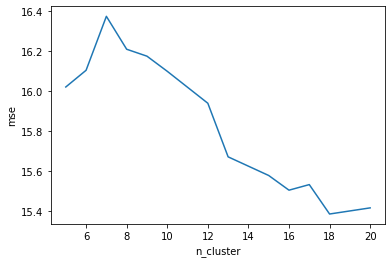

In [793]:
lst = []

for i in range(15, 60, 1):
    model_agglo_tst = AgglomerativeClustering(distance_threshold=i,n_clusters=None)
    train['hier_clust'] = model_agglo_tst.fit_predict(training)
    med_val = train.groupby(['hier_clust'], as_index = False)['FPTS/G'].median()
    med_val = med_val.rename(columns={'FPTS/G':'Pred_PPG'})
    train_out = train.merge(med_val, how = "left", on =['hier_clust'])
    score = train_out[['PPG','Pred_PPG']][train_out['PPG'].notna()]
    mse = mean_squared_error(score['PPG'],score['Pred_PPG'])
    lst.append((i,model_agglo_tst.n_clusters_,mse))

results = pd.DataFrame(lst, columns=['dist','n_cluster','mse'])

unique_res = results[['n_cluster','mse']].drop_duplicates()
sns.lineplot(data = unique_res, x = 'n_cluster', y = 'mse')

Now, we will run an Affinity Propagation algorithm. The great thing about Affinity Progragation clustering is that you do not need to state the number of clusters beforehand.  The algorithm finds cluster centers automatically.

The model seems to provide decent stratification accross 'PPG' and decent cluster separation using the default hyperparameters. I did play around with the 

<AxesSubplot:xlabel='aff_clust', ylabel='PPG'>

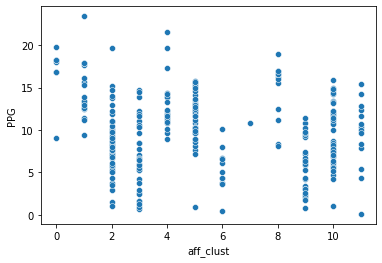

In [797]:
training = train[['YDS','TD','YDS.1','TD.1']]

model_aff = AffinityPropagation(random_state=6)
af = AffinityPropagation(random_state=5).fit(training)
train['aff_clust'] = model_aff.fit_predict(training)
sns.scatterplot(x=train['aff_clust'],y=train['PPG'])

In [798]:
round(silhouette_score(training, af.labels_ ),3)

0.409

The Mean Square Error is in a little better than the the hierarchical clustering model.

In [777]:
med_val = train.groupby(['aff_clust'], as_index = False)['FPTS/G'].median()
med_val = med_val.rename(columns={'FPTS/G':'Pred_PPG_aff'})
train_out = train.merge(med_val, how = "left", on =['aff_clust'])
score = train_out[['PPG','Pred_PPG_aff']][train_out['PPG'].notna()]
round(mean_squared_error(score['PPG'],score['Pred_PPG_aff']),3)

15.968

Now, let's see how the two models look using the testing data

In [778]:
testing = test[['YDS','TD','YDS.1','TD.1']]
test['hier_clust'] = model_agglo_out.fit_predict(testing)
test['aff_clust'] = model_aff.fit_predict(testing)

The clusters are not ordered.  So, we will create 'rank' columns that order the clustes by the current year's PPG.  Note, we are using the current year's PPG to order the clusters, not the 'PPG' field which we use to evaluate.

In [779]:
hier_rank = test.groupby('hier_clust',as_index=False)['FPTS/G'].mean()
hier_rank= hier_rank.sort_values(by=['FPTS/G'], ascending=False)
hier_rank['hier_rank'] = range(1, len(hier_rank) + 1)

aff_rank = test.groupby('aff_clust',as_index=False)['FPTS/G'].mean()
aff_rank= aff_rank.sort_values(by=['FPTS/G'], ascending=False)
aff_rank['aff_rank'] = range(1, len(aff_rank) + 1)

hier_rank = hier_rank[['hier_clust','hier_rank']]
aff_rank = aff_rank[['aff_clust','aff_rank']]

test = test.merge(hier_rank, how="left",on="hier_clust")
test = test.merge(aff_rank, how="left",on="aff_clust")

In [780]:
test[['Player','year','hier_clust','aff_clust','hier_rank','aff_rank']].head(8)

,Player,year,hier_clust,aff_clust,hier_rank,aff_rank
0,Justin Jefferson,2022,4,0,1,1
1,Davante Adams,2022,2,1,2,2
2,Tyreek Hill,2022,4,0,1,1
3,Stefon Diggs,2022,2,1,2,2
4,A.J. Brown,2022,2,1,2,2
5,CeeDee Lamb,2022,2,1,2,2
6,Jaylen Waddle,2022,2,1,2,2
7,Amon-Ra St. Brown,2022,2,2,2,3


In [803]:
hier_sum = test.groupby(['hier_rank'])['PPG'].describe()
hier_sum.round(1)

,count,mean,std,min,25%,50%,75%,max
hier_rank,,,,,,,,
1,2.0,18.3,2.1,16.8,17.6,18.3,19.0,19.8
2,11.0,14.1,2.8,10.9,12.1,13.3,15.6,19.7
3,11.0,10.5,1.8,7.2,9.6,9.9,11.7,13.6
4,18.0,8.4,3.5,1.0,6.8,8.4,11.0,14.0
5,20.0,6.6,4.0,0.4,3.6,6.4,8.6,14.7


In [805]:
aff_sum = test.groupby(['aff_rank'])['PPG'].describe()
aff_sum.round(1)

,count,mean,std,min,25%,50%,75%,max
aff_rank,,,,,,,,
1,2.0,18.3,2.1,16.8,17.6,18.3,19.0,19.8
2,8.0,13.3,2.8,10.9,11.5,12.8,13.4,19.7
3,14.0,11.7,3.0,7.2,9.7,11.0,13.4,17.3
4,1.0,14.2,NaN,14.2,14.2,14.2,14.2,14.2
5,11.0,9.3,2.7,4.2,7.6,9.1,11.7,13.2
6,15.0,7.0,4.1,1.0,4.0,6.6,9.2,14.7
7,11.0,5.7,3.4,0.4,2.8,6.0,8.1,10.6


In [784]:
out = output[['YDS','TD','YDS.1','TD.1']]
output['hier_clust'] = model_agglo_out.fit_predict(out)
output['aff_clust'] = model_aff.fit_predict(out)
output = output[['Player','FPTS/G','PPG','hier_clust','aff_clust']]

consensus_merge = consensus.merge(output, how = "inner", on = "Player")

In [813]:
hier_rank = consensus_merge.groupby('hier_clust',as_index=False)['FPTS/G'].mean()
hier_rank= hier_rank.sort_values(by=['FPTS/G'], ascending=False)
hier_rank['hier_rank'] = range(1, len(hier_rank) + 1)

aff_rank = consensus_merge.groupby('aff_clust',as_index=False)['FPTS/G'].mean()
aff_rank= aff_rank.sort_values(by=['FPTS/G'], ascending=False)
aff_rank['aff_rank'] = range(1, len(aff_rank) + 1)

hier_rank = hier_rank[['hier_clust','hier_rank']]
aff_rank = aff_rank[['aff_clust','aff_rank']]

consensus_merge = consensus_merge.merge(hier_rank, how="inner",on="hier_clust")
consensus_merge = consensus_merge.merge(aff_rank, how="inner",on="aff_clust")

In [814]:
consensus_merge[['Player','TIERS','hier_rank','aff_rank','FPTS/G','PPG']].head(10)

,Player,TIERS,hier_rank,aff_rank,FPTS/G,PPG
0,CeeDee Lamb,1,1,1,19.7,15.4
1,Tyreek Hill,1,1,1,19.8,12.1
2,Justin Jefferson,2,1,1,16.8,19.0
3,Amon-Ra St. Brown,1,1,2,17.0,16.4
4,Keenan Allen,6,1,2,17.3,9.8
5,A.J. Brown,2,2,2,13.9,23.3
6,Puka Nacua,3,2,2,14.5,8.2
7,Nico Collins,4,2,2,14.7,21.3
8,Brandon Aiyuk,4,2,2,13.2,9.7
9,DJ Moore,4,2,2,14.0,13.5


In [815]:
consensus_sum = consensus_merge.groupby(['TIERS'])['PPG'].describe().sort_values(by=['TIERS'], ascending=True)
consensus_sum.round(1)

,count,mean,std,min,25%,50%,75%,max
TIERS,,,,,,,,
1,4.0,16.0,3.3,12.1,14.6,15.9,17.3,20.1
2,3.0,18.9,4.4,14.5,16.8,19.0,21.2,23.3
3,4.0,12.5,4.5,8.2,9.0,12.2,15.6,17.5
4,9.0,14.4,4.2,9.5,10.7,14.3,16.6,21.3
5,4.0,14.2,3.0,10.2,12.8,14.7,16.0,17.0
6,9.0,12.4,4.2,7.6,9.8,9.9,14.5,20.7
7,3.0,12.3,5.1,7.5,9.6,11.8,14.8,17.7
8,7.0,8.2,4.5,0.0,6.0,10.1,11.5,12.1
9,9.0,8.6,4.0,2.9,6.1,8.3,9.8,15.7


In [808]:
curr_hier_sum = consensus_merge.groupby(['hier_rank'])['PPG'].describe()
curr_hier_sum.round(1)

,count,mean,std,min,25%,50%,75%,max
hier_rank,,,,,,,,
1,5.0,14.5,3.6,9.8,12.1,15.4,16.4,19.0
2,7.0,13.0,6.9,4.9,9.0,10.2,17.4,23.3
3,12.0,13.0,3.7,9.3,9.8,12.5,15.4,20.1
4,20.0,12.0,5.5,1.9,7.6,12.8,15.8,20.7
5,13.0,8.7,4.1,0.0,7.0,9.1,10.1,15.7


In [809]:
curr_aff_sum = consensus_merge.groupby(['aff_rank'])['PPG'].describe()
curr_aff_sum.round(1)

,count,mean,std,min,25%,50%,75%,max
aff_rank,,,,,,,,
1,3.0,15.5,3.5,12.1,13.8,15.4,17.2,19.0
2,9.0,13.0,6.2,4.9,9.7,10.2,16.4,23.3
3,11.0,13.3,3.7,9.3,9.9,14.3,15.8,20.1
4,11.0,13.1,5.1,7.5,8.0,14.5,16.8,20.7
5,13.0,10.1,4.9,1.9,7.0,11.0,13.6,17.7
6,10.0,8.7,4.7,0.0,6.6,9.4,11.4,15.7


**Conclusion**

Both models seem to perform well at providing stratified predictions for 'PPG' for last season.  So far this season, there is not as much separation between the clusters as there was in the previous year.  I wanted to look at this year to compare to the "Consensus TIERS".  However, through week 5, it is too early to tell how well the clusters are performing.  If the clusters eventually perform as well as the previous season, the clusters will be helpful in determining next year's draft strategy.

In the future, I would like to use some advanced stats for WRs, like 'air yards' and 'win rate'.  In addition, I would like to implement some automatic feature generation.  I did not do automatic feature generation here because I wanted to view the charts as I when through different feature permutations. Further, I plan on exploring different clustering algorithms.

I am very pleased with the results of the Affinity Propagation algorithm and plan to use in more projects in the future.  It is very easy to implement and does not require prior knowledge of the number of clusters.  In the future, I would like to iterate through the different hyperparameters.  However, the default parameters worked well.  Also, I did manually change them a few times and did not notice much of a change in the modelling results. 

For the hierarchical clustering algorithm, I would like to iterate through different linkages and distance metrics to see if they improve the MSE.  However, I am happy with the results of the clustering algorithm, as is.


**References**

Kapania, Nitin, 2010, "Predicting Fantasy Football Performance with Machine Learning Techniques": https://cs229.stanford.edu/proj2012/Kapania-FantasyFootballAndMachineLearning.pdf

Ninja, Neural, 2023, "Affinity Propagation: Demystifying Exemplar-Based Clustering":https://letsdatascience.com/affinity-propagation-clustering/

2020, "8 Clustering Algorithms in Machine Learning that All Data Scientists Should Know": https://www.freecodecamp.org/news/8-clustering-algorithms-in-machine-learning-that-all-data-scientists-should-know/#:~:text=The%20Top%208%20Clustering%20Algorithms%201%20K-means%20clustering,algorithm%20...%205%20Affinity%20Propagation%20clustering%20algorithm%20